In [1]:
# Installations steps required before running this notebook can be found here:
# https://automating-gis-processes.github.io/2017/course-info/Installing_Anacondas_GIS.html
#
# Conda packages:
# conda install -c conda-forge osmnx
#
# *Installation via pip is not possible
#
#
# Further packages should be downloaded to make sure that everything works 
# as written in GeoPython documentation, however, I limit the requirements 
# mentioned here to the minimum needed.

In [1]:
# Import of libraries
import osmnx as ox
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# This is used to ignore the major warnings during the scraping process
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The place name is defined.
# Following notation is strongly recommended: Village, Province, Country.
place_name = "Reggio Emilia, Reggio Emilia, Italia"

In [4]:
# The graph of streets is downloaded.
# The parameter network_type defines the street in the user's interest.
# The possibilities are: drive, bike, walk
graph = ox.graph_from_place(place_name, network_type='drive')

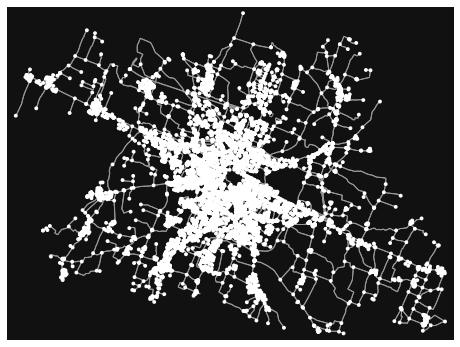

In [5]:
fig, ax = ox.plot_graph(graph)

In [6]:
# To get the edges of the graph (fill_edge_geometry is just an additional parameter
# used to have a forecast of missing informations)
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True, fill_edge_geometry=True)

In [7]:
# To get the nodes of the graph
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)

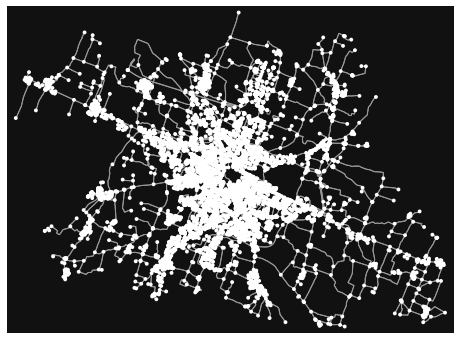

<Figure size 432x288 with 0 Axes>

In [8]:
# A better printing of the graph
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)
plt.tight_layout()

In [9]:
# Here the nodes and edges are provided, but in an UTM easy-to-handle format
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [ ]:
# Some basic statistics concerning the extraction (!!! Long computational time)
area = edges_proj.unary_union.convex_hull.area
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

In [55]:
# Given the coordinates of two nodes expressed in (lat, long), the closets nodes
# belonging to our set are found.
# Note the haversine function is used,
o, t = nodes_proj.sample(), nodes_proj.sample()
origin = (o["lat"], o["lon"])  # lat, long
target = (t["lat"], t["lon"])   # lat, long
orig_node = ox.get_nearest_node(graph_proj, origin, method='haversine')
target_node = ox.get_nearest_node(graph_proj, target, method='haversine')
o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]
print("Origin")
print(o_closest)
print()
print("Target")
print(t_closest)

Origin
y                                          4.94786e+06
x                                               622023
osmid                                       1035824149
lon                                            10.5395
lat                                            44.6737
highway                                            NaN
ref                                                NaN
geometry    POINT (622022.579583139 4947855.389735592)
Name: 1035824149, dtype: object

Target
y                                           4.95138e+06
x                                                629938
osmid                                        3827635467
lon                                             10.6402
lat                                              44.704
highway                                             NaN
ref                                                 NaN
geometry    POINT (629937.7016061469 4951375.501311333)
Name: 3827635467, dtype: object


In [56]:
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)

In [72]:
def euclidean (n1, n2):
    x1, y1 = n1; x2, y2 = n2
    return ((x1 - x2)**2 + (y1 - y2))**0.5

In [59]:
route = nx.shortest_path(G=graph_proj,
                         source=orig_node,
                         target=target_node,
                         weight='length',
                         method='bellman-ford'  #'dijkstra' 'bellman-ford'
                        )

In [78]:
route_astar = nx.astar_path (G=graph_proj,
                              source=orig_node,
                              target=target_node,
                              weight='length',
                              heuristic=None
                             )

In [81]:
route_fw = nx.floyd_warshall_numpy(G=graph_proj, nodelist=None, weight='length')

KeyboardInterrupt: 

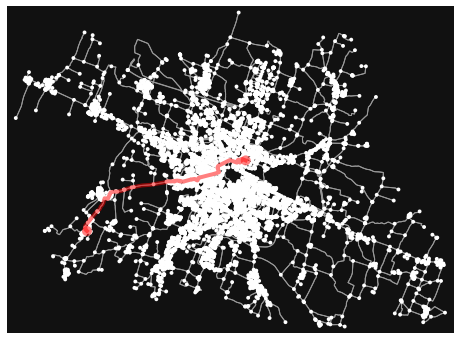

In [60]:
fig, ax = ox.plot_graph_route(graph_proj, route)


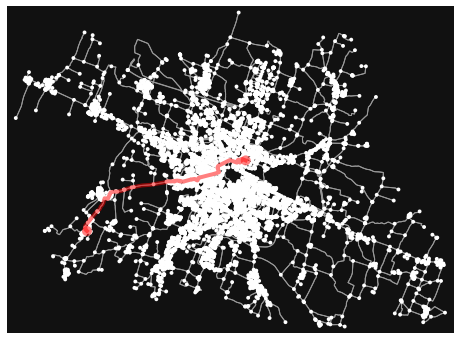

In [79]:
fig, ax = ox.plot_graph_route(graph_proj, route_astar)

In [ ]:
fig, ax = ox.plot_graph_route(graph_proj, route_fw)

In [105]:
route_nodes = nodes_proj.loc[route]
route_nodes

,y,x,osmid,lon,lat,highway,ref,geometry
1035824149,4.947855e+06,622022.579583,1035824149,10.539494,44.673691,NaN,NaN,POINT (622022.580 4947855.390)
1035823827,4.947894e+06,621978.791192,1035823827,10.538951,44.674048,NaN,NaN,POINT (621978.791 4947894.244)
950697444,4.947919e+06,621944.586222,950697444,10.538525,44.674277,NaN,NaN,POINT (621944.586 4947918.989)
2515715002,4.948028e+06,621934.740349,2515715002,10.538427,44.675257,NaN,NaN,POINT (621934.740 4948027.646)
1035823763,4.948274e+06,622064.210831,1035823763,10.540119,44.677450,NaN,NaN,POINT (622064.211 4948273.781)
...,...,...,...,...,...,...,...,...
438041756,4.951274e+06,629659.610778,438041756,10.636674,44.703114,NaN,NaN,POINT (629659.611 4951273.859)
845407195,4.951311e+06,629677.396683,845407195,10.636908,44.703447,NaN,NaN,POINT (629677.397 4951311.244)
845407049,4.951380e+06,629708.570547,845407049,10.637319,44.704064,NaN,NaN,POINT (629708.571 4951380.436)
3827635469,4.951451e+06,629735.967578,3827635469,10.637683,44.704694,NaN,NaN,POINT (629735.968 4951450.997)


In [114]:
from shapely.geometry import LineString, Point

route_line = LineString(list(route_nodes.geometry.values))
route_line.length

10269.928336289287